In [1]:
from matplotlib import pyplot as plt

In [2]:
import netcomp as nc

# use if making graphics for a presentation
plt.style.use(['classic','ggplot'])

figures_dir = '/Users/peterwills/google-drive/Research/Graph Distance Study/metrics_paper/figures'

# Get data from web

In [ ]:
%%bash
cd data
curl -O http://snap.stanford.edu/data/email-Eu-core-temporal.txt.gz
gunzip email-Eu-core-temporal.txt.gz

# grab metadata too

In [3]:
ls ./data

CollegeMsg.txt                          email-Eu-core-temporal.txt
abide_connectivity.mat                  metadata_primaryschool.txt
dnc.tsv                                 primaryschool.csv
download.tsv.dnc-temporalGraph.tar.bz2


# Load in data

We have a bunch of time-stamped edges in a csv. We need to turn these into a sequence of graphs so that we can look at the resistance distance between timesteps. Let's see how this does.

In [4]:
import pandas as pd

In [5]:
import os
os.getcwd()

'/Users/peterwills/code/python/graph_metrics_paper_code'

In [6]:
full_data = pd.read_csv('./data/email-Eu-core-temporal.txt',sep=' ',header=None)

In [8]:
full_data.columns = ['i','j','ts']

In [9]:
seconds_per_day = 60*60*24
full_data['day_num'] = full_data['ts'] // seconds_per_day

In [10]:
seconds_per_week = 60*60*24*7
full_data['week_num'] = full_data['ts'] // seconds_per_week

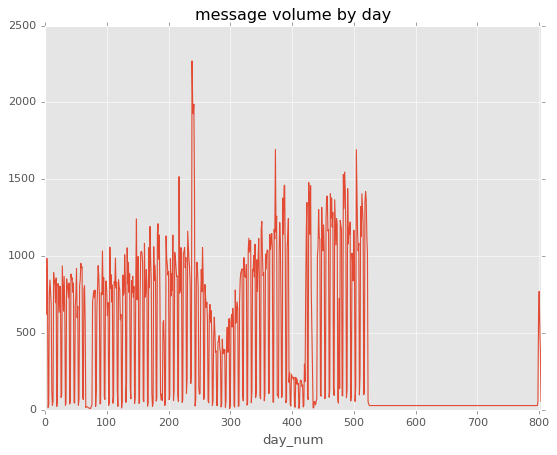

In [11]:
full_data.groupby('day_num').count()['ts'].plot()
plt.title('message volume by day');

The data here oscillates heavily on a daily basis, so we'll do two things:

1. We'll group into weekly buckets
2. We'll drop the late-occuring data.

In [12]:
full_data.head()

,i,j,ts,day_num,week_num
0,582,364,0,0,0
1,168,472,2797,0,0
2,168,912,3304,0,0
3,2,790,4523,0,0
4,2,322,7926,0,0


In [13]:
full_data = full_data[full_data['ts'] < 600 * seconds_per_day]

The data appears to have a two-day periodicity in it, so we'll group at the two-day
level. This should give us some resolution that we don't see at the week level.

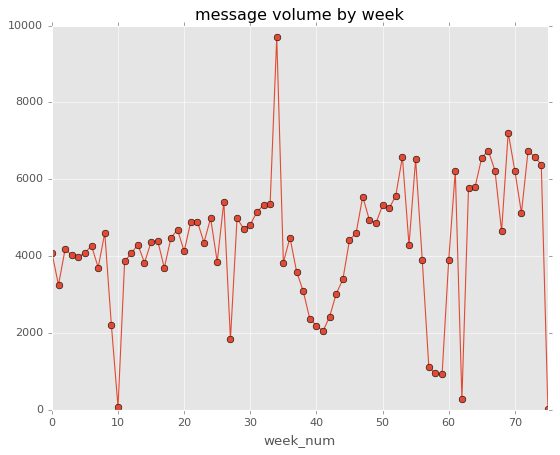

In [14]:
full_data.groupby('week_num').count()['ts'].plot(style='o-')
plt.title('message volume by week');

Note that the starting timestamp (`ts=0`) is not the beginning of the Unix epoch - what I can gather from "Graph Evolution: Densification and Shrinking Diameters" (Leskovic et al. 2007) is that it starts in October 2003.

In [15]:
import networkx as nx

In [34]:
graphs = []
amats = []
amats_clean = []
dates = []
start_date = pd.to_datetime('10-01-2003')

all_ids = list(full_data['i']) + list(full_data['j'])

for week_num, df in full_data.groupby('week_num'):
    G = nx.Graph()
    G.add_nodes_from(all_ids)
    df_both_ways =  pd.merge(
        df[['i','j']],
        df[['i','j']].rename({'i': 'j', 'j': 'i'}, axis=1),
        on=['i', 'j']
    ).drop_duplicates()
    G.add_edges_from(zip(df_both_ways['i'],df_both_ways['j']))
    graphs.append(G)
    amats.append(nx.adjacency_matrix(G))
    G.remove_nodes_from(nx.isolates(G))
    amats_clean.append(nx.adjacency_matrix(G))
    dates.append(start_date + pd.Timedelta(weeks=week_num))

dates = dates[1:]

# Analysis

Let's take the renormalized resistance distance between each graph, along with the edit distance, and see what we can see.

In [17]:
def vol_dist(A1,A2):
    """Volume difference between two graphs."""
    return np.abs(A1.sum() - A2.sum())/2

In [18]:
import numpy as np

In [19]:
from tqdm import tqdm

The below will take some time. `tqdm` will tell you the approximate time per iteration, and there are about 75 weeks to iterate over.

In [21]:
%%time

r_dists = []
e_dists = []
d_dists = []
ns_dists = []
adj_dists = []
lap_dists = []
nlap_dists = []
vol_dists = []

for A_old,A in tqdm(zip(amats[:-1],amats[1:])):
    r_dists.append(nc.resistance_distance(A,A_old,renormalized=True))
    e_dists.append(nc.edit_distance(A,A_old))
    d_dists.append(nc.deltacon0(A,A_old))
    ns_dists.append(nc.netsimile(A,A_old))
    adj_dists.append(nc.lambda_dist(A,A_old,kind='adjacency'))
    lap_dists.append(nc.lambda_dist(A,A_old,kind='laplacian'))
    nlap_dists.append(nc.lambda_dist(A,A_old,kind='laplacian_norm'))
    vol_dists.append(vol_dist(A,A_old))

75it [03:23,  2.71s/it]

CPU times: user 8min 22s, sys: 51.8 s, total: 9min 14s
Wall time: 3min 23s


In [22]:
# normalize by sample mean
r_dists = r_dists/np.mean(r_dists)
e_dists = e_dists/np.mean(e_dists)
d_dists = d_dists/np.mean(d_dists)
ns_dists = ns_dists/np.mean(ns_dists)
adj_dists = adj_dists/np.mean(adj_dists)
lap_dists = lap_dists/np.mean(lap_dists)
nlap_dists = nlap_dists/np.mean(nlap_dists)
vol_dists = vol_dists/np.mean(vol_dists)

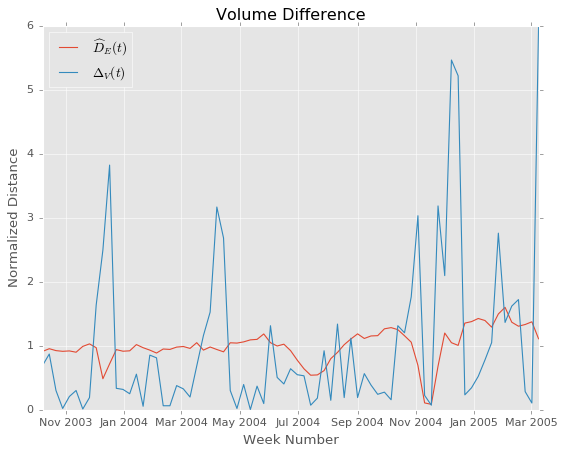

In [39]:
# plot curves
plt.plot(dates,e_dists,label='$\widehat{D}_E(t)$');
plt.plot(dates,vol_dists,label='$\Delta_V(t)$');
plt.xlabel('Week Number');
plt.ylabel('Normalized Distance');
plt.title('Volume Difference');
plt.legend(loc=2);

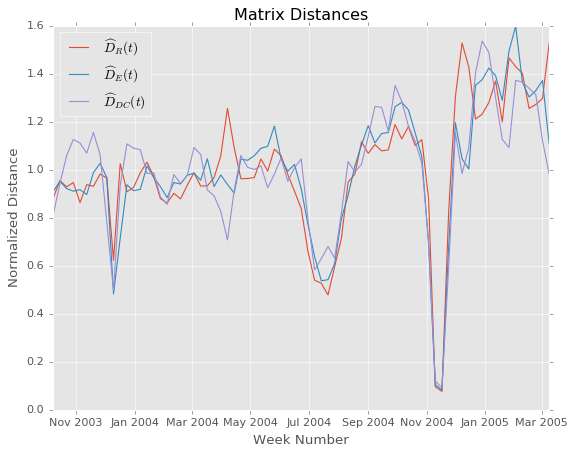

In [37]:

# plot curves
plt.plot(dates,r_dists,label='$\widehat{D}_R(t)$');
plt.plot(dates,e_dists,label='$\widehat{D}_E(t)$');
plt.plot(dates,d_dists,label='$\widehat{D}_{DC}(t)$');

plt.xlabel('Week Number');
plt.ylabel('Normalized Distance');
plt.title('Matrix Distances');
plt.legend(loc=2);

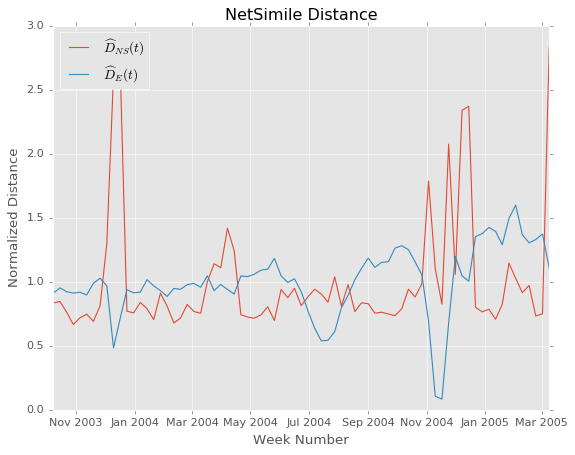

In [40]:
# plot curves
plt.plot(dates,ns_dists,label='$\widehat{D}_{NS}(t)$');
plt.plot(dates,e_dists,label='$\widehat{D}_E(t)$');


plt.xlabel('Week Number');
plt.ylabel('Normalized Distance');
plt.title('NetSimile Distance');
plt.legend(loc='upper left');
plt.legend(loc=2);

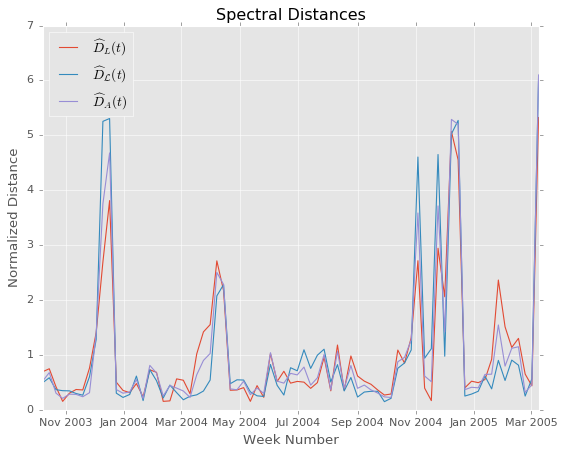

In [41]:
# plot curves
plt.plot(dates,lap_dists,label='$\widehat{D}_{L}(t)$');
plt.plot(dates,nlap_dists,label='$\widehat{D}_{\mathcal{L}}(t)$');
plt.plot(dates,adj_dists,label='$\widehat{D}_{A}(t)$');

# axes labels & title
plt.xlabel('Week Number');
plt.ylabel('Normalized Distance');
plt.title('Spectral Distances');
plt.legend(loc='upper left');